In [1]:
import tensorflow as tf
import keras
import sys, os
print(tf.__version__)
sys.path.append("/Users/inkeejung/Library/CloudStorage/Dropbox-BOSTONUNIVERSITY/Inkee Jung/Inkee Jung’s files/Interpretability/AdvLogifold/computer/modules")
dropbox_path = "/Users/inkeejung/Library/CloudStorage/Dropbox-BOSTONUNIVERSITY/Inkee Jung/Inkee Jung’s files/Interpretability/AdvLogifold/computer/"
base_models_path = dropbox_path + 'Base_Models/'
adversarial_examples_path = dropbox_path + 'Adversarial_Examples/'
adversarial_models_path = dropbox_path + 'Adversarial_Models/'
from keras.models import Model, load_model
from keras.datasets import cifar10
import logifoldv1_4 as logifold
from sklearn.model_selection import train_test_split
import numpy as np
from resnet import ResNet
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import layers
import pickle
import pandas as pd
print('Modules are loaded.')

2025-01-23 20:17:19.058870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2.10.0
Modules are loaded.


# Preprocessing Data

x_train = x_tr, x_val = x_v 

y_train = y_tr, y_val = y_v

adv_x_train, adv_x_val, adv_x_test = adversarial examples

In [2]:
(x, y), (x_test, y_test)= cifar10.load_data()
x_tr, x_v, y_tr, y_v = train_test_split(x, y, test_size=0.2, random_state=42)
x_tr = x_tr.reshape(x_tr.shape[0],32,32,3)
x_v = x_v.reshape(x_v.shape[0],32,32,3)
x_v = x_v.astype('float32')
x_tr = x_tr.astype('float32')
x_v /= 255
x_tr /= 255
x_train, x_val, y_train, y_val = x_tr,x_v,y_tr,y_v
x_test = x_test.reshape(x_test.shape[0],32,32,3)
x_test = x_test.astype('float32')
x_test /= 255


adv_x_tr = np.load(adversarial_examples_path + "pgd_0.376_x_untarget.npy")
adv_x_val = np.load(adversarial_examples_path + "pgd_0.376_x_val_untarget.npy")
adv_x_test = np.load(adversarial_examples_path+"pgd_0.376_x_test_untarget.npy")
print('original and adversarial dataset has been loaded.')

original and adversarial dataset has been loaded.


training_x, validating_x, testing_x : Polluted data, 1:1, adversaries obtained from ResNet56v1, PGD method with $\epsilon = 0.396$, untargeted. First half is original part, and the other is adversaries.

training_y_long, validating_y_long, testing_y_long : original and adversaries, half and half

filter_y_tr : 80k number of data, consisting of $0$ or $1$ (1:1)

filter_y_val : 20k number of data

In [4]:
January_test_logifold_path = dropbox_path + 'testfolder/logifold_test202501/'

In [5]:
october_test_logifold_path = dropbox_path + 'testfolder/logifold_test20241124/'

training_y_long=np.concatenate([y_train,y_train+10],axis=0)
training_y_long = keras.utils.to_categorical(training_y_long,20)
validating_y_long=np.concatenate([y_v,y_v+10],axis=0)
validating_y_long = keras.utils.to_categorical(validating_y_long,20)
testing_y_long=np.concatenate([y_test,y_test+10],axis=0)
testing_y_long = keras.utils.to_categorical(testing_y_long,20)

filter_y_tr = np.zeros((40000,1),dtype='uint8')
filter_y_tr=np.concatenate([filter_y_tr,filter_y_tr+1],axis=0)
filter_y_tr = keras.utils.to_categorical(filter_y_tr,2)
filter_y_val = np.zeros((10000,1),dtype='uint8')
filter_y_val=np.concatenate([filter_y_val,filter_y_val+1],axis=0)
filter_y_val = keras.utils.to_categorical(filter_y_val,2)

training_x = np.concatenate([x_tr,adv_x_tr],axis=0)
validating_x = np.concatenate([x_v,adv_x_val],axis=0)
testing_x = np.concatenate([x_test,adv_x_test],axis=0)

                                          
lgfd_prev = logifold.Logifold(20,
                        name = "test202501",
                        x_tr = training_x,
                        y_tr = training_y_long,
                        x_v = validating_x,
                        y_v = validating_y_long, 
                        path = october_test_logifold_path,
                        storyFile='story_202501_00')
lgfd_prev.load()
filter_from_base = lgfd_prev.getModel((0,0,2))
filter_from_fullandfind = lgfd_prev.getModel((0,0,1))

2025-01-23 20:17:45.266249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


lgfd_prev : logifold constructed in previous experiment

filter_from_base : Specialized model from base ResNet56v1, included in the lgfd_prev

filter_from_fullandfine : specialized model from the full and fine model in the lgfd_prev

In [19]:
from typing import Tuple
def shuffle_dataset(
    ratio_of_adv_to_original: float, 
    original_dataset: Tuple[np.ndarray, np.ndarray], 
    adv_dataset: Tuple[np.ndarray, np.ndarray],
    num_classes: int = 10
) -> Tuple[int, np.ndarray, np.ndarray]:


    """
    Mixes the original dataset with the adversarial dataset based on the given ratio.

    Parameters:
    - ratio_of_adv_to_original (float): The ratio of adversarial samples to original samples.
    - original_dataset (np.ndarray): The original dataset.
    - adv_dataset (np.ndarray): The adversarial dataset.

    Returns:
    - np.ndarray: The shuffled combined dataset.
    """
    
    if not (isinstance(original_dataset, tuple) and isinstance(adv_dataset, tuple)):
        raise TypeError("original_dataset and adv_dataset must be tuples of NumPy arrays.")

    if not (isinstance(original_dataset[0], np.ndarray) and isinstance(original_dataset[1], np.ndarray)):
        raise TypeError("Elements of original_dataset must be NumPy arrays.")

    if not (isinstance(adv_dataset[0], np.ndarray) and isinstance(adv_dataset[1], np.ndarray)):
        raise TypeError("Elements of adv_dataset must be NumPy arrays.")

    if not (0 <= ratio_of_adv_to_original <= 1):
        raise ValueError("ratio_of_adv_to_original must be between 0 and 1.")
    
    if original_dataset[0].shape[1:] != adv_dataset[0].shape[1:]:
        raise ValueError("original_dataset and adv_dataset must have the same shape except for the first dimension.")
    
    num_adv = int(len(original_dataset[0]) * ratio_of_adv_to_original)
    
    np.random.seed(42)
    random_indices = np.random.choice(len(original_dataset[0]), num_adv, replace=False)
    adv_sample = adv_dataset[0][random_indices]
    combined_x = np.concatenate((original_dataset[0], adv_sample))
    combined_y = np.concatenate((original_dataset[1],adv_dataset[1][random_indices]+num_classes))
    combined_y =  keras.utils.to_categorical(combined_y, num_classes=2*num_classes)
    return num_adv, combined_x, combined_y



In [37]:
import collections
answers = collections.defaultdict(int)
answer_ratios = collections.defaultdict(float)
for ratio in [1/2,1/3,1/4,1/5,1/10]:
    shuffle_datasets = shuffle_dataset(ratio,(x_test,y_test),(adv_x_test,y_test))
    shuffle_datasets_x, shuffle_datasets_y = shuffle_datasets[1], shuffle_datasets[2]
    answer = np.argmax(filter_from_base.predict(shuffle_datasets_x),axis=-1)
    answer_y = np.argmax(shuffle_datasets_y,axis=-1)
    answer_ratios[ratio] = np.sum(answer == 1)/len(answer)
    answers[ratio] = np.sum(answer == answer_y//10)

344/344 [==============================] - 33s 96ms/step


In [46]:
print('ratio --- accuracy --- predicted pollution ratio')
for key, value in answers.items():
    print(key/(key+1), value, answer_ratios[key])
    # print(round(answer_ratios[key]/(1-answer_ratios[key]),2))

ratio --- accuracy --- predicted pollution ratio
0.3333333333333333 14940 0.3316
0.25 13288 0.24915622890572264
0.2 12463 0.19976
0.16666666666666669 11966 0.16666666666666666
0.09090909090909091 10978 0.092


In [45]:
adv_CWL2_targeted_to_second_likely = np.load(adversarial_examples_path + "cwl2_x_test_targeted_to_2nd.npy")
adv_CWL2_targeted_to_least_likely = np.load(adversarial_examples_path + "cwl2_x_test_targeted_to_ll.npy")
adv_CWL2_untargeted = np.load(adversarial_examples_path+"cwl2_x_test_untargeted.npy")

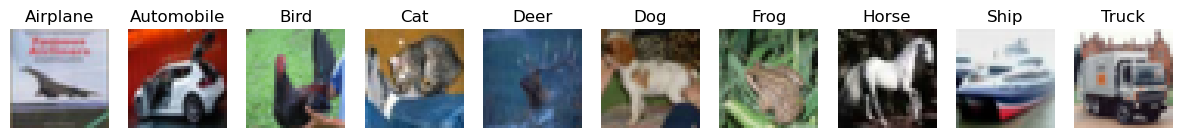

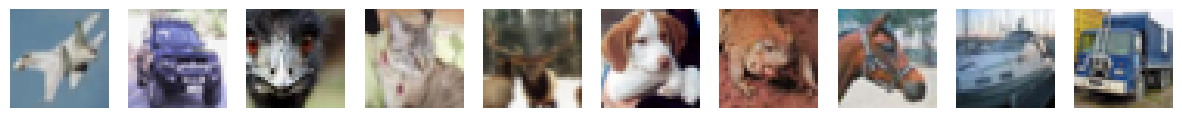

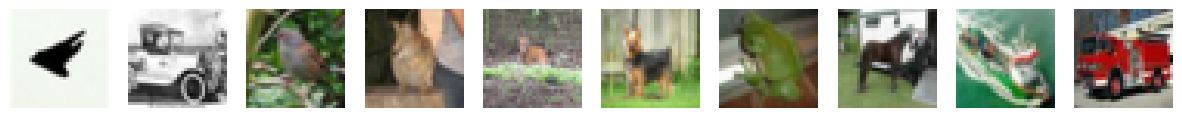

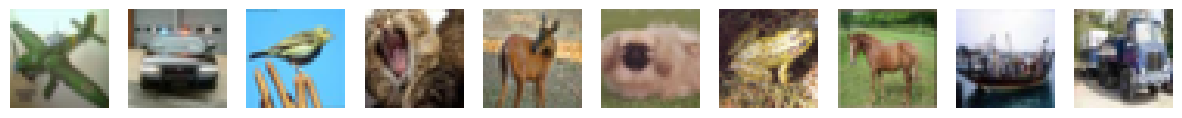

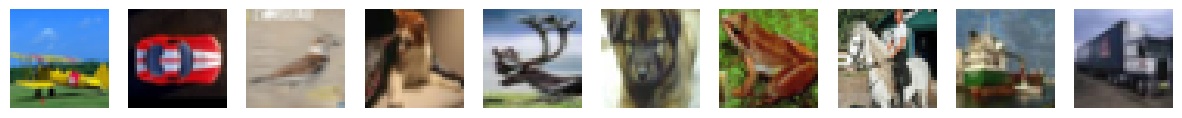

In [51]:
# Testing dataset samples
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for j in range(5):
    samples = []
    for i in range(10):
        idx = np.where(np.argmax(keras.utils.to_categorical(y_test, num_classes=10),axis=-1) == i)[0][j]  
        samples.append(x_test[idx])
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))  
    for i, ax in enumerate(axes):
        ax.imshow(samples[i])
        if j==0:
            ax.set_title(class_names[i])
        ax.axis('off') 

    plt.show()


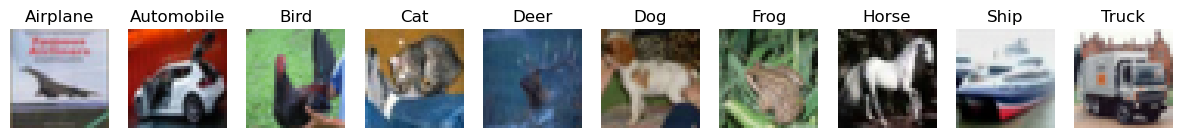

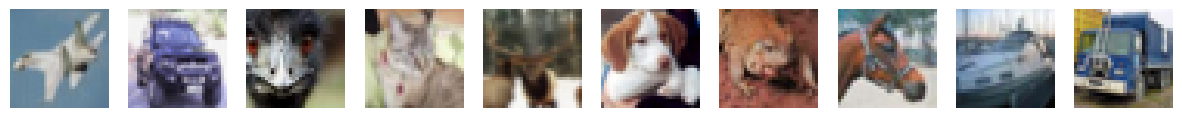

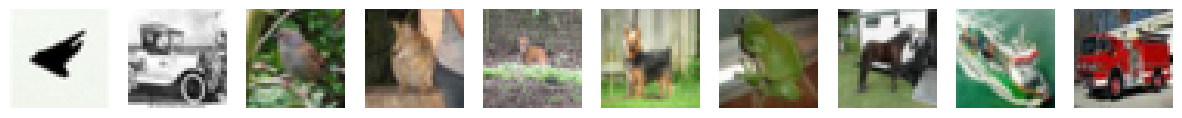

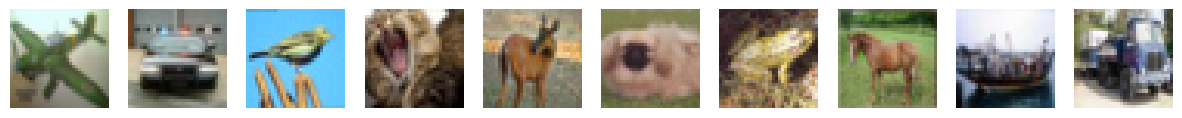

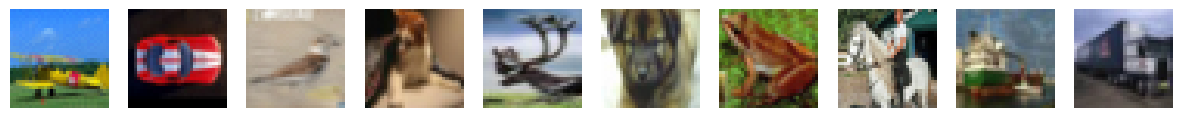

In [50]:

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for j in range(5):
    samples = []
    for i in range(10):
        idx = np.where(np.argmax(keras.utils.to_categorical(y_test, num_classes=10),axis=-1) == i)[0][j]  
        samples.append(adv_CWL2_targeted_to_second_likely[idx])
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))  
    for i, ax in enumerate(axes):
        ax.imshow(samples[i])
        if j==0:
            ax.set_title(class_names[i])
        ax.axis('off') 

    plt.show()


In [52]:
base_model = lgfd_prev.getModel((0,0,0))

In [53]:
np.sum(
    np.argmax(base_model.predict(x_test),axis=-1) == np.argmax(keras.utils.to_categorical(y_test, num_classes=10),axis=-1)
)

313/313 [==============================] - 28s 87ms/step


8785

In [54]:
np.sum(
    np.argmax(base_model.predict(adv_CWL2_targeted_to_second_likely),axis=-1) == np.argmax(keras.utils.to_categorical(y_test, num_classes=10),axis=-1)
)

313/313 [==============================] - 26s 82ms/step


895

In [55]:
answers = collections.defaultdict(int)
answer_ratios = collections.defaultdict(float)
for ratio in [1, 1/2,1/3,1/4,1/5,1/10]:
    shuffle_datasets = shuffle_dataset(ratio,(x_test,y_test),(adv_CWL2_targeted_to_second_likely,y_test))
    shuffle_datasets_x, shuffle_datasets_y = shuffle_datasets[1], shuffle_datasets[2]
    answer = np.argmax(filter_from_base.predict(shuffle_datasets_x),axis=-1)
    answer_y = np.argmax(shuffle_datasets_y,axis=-1)
    answer_ratios[ratio] = np.sum(answer == 1)/len(answer)
    answers[ratio] = np.sum(answer == answer_y//10)
print('Adversaries : CWL2 method , modified to second likely')
print('ratio --- accuracy --- predicted pollution ratio')
for key, value in answers.items():
    print(key/(key+1), value, answer_ratios[key])


344/344 [==============================] - 30s 87ms/step
Adversaries : CWL2 method , modified to second likely
ratio --- accuracy --- predicted pollution ratio
0.5 10081 0.00575
0.3333333333333333 10035 0.0046
0.25 10020 0.004050101252531313
0.2 10004 0.00304
0.16666666666666669 9999 0.00275
0.09090909090909091 9991 0.0022727272727272726


In [56]:

answers = collections.defaultdict(int)
answer_ratios = collections.defaultdict(float)
for ratio in [1/2,1/3,1/4,1/5,1/10]:
    shuffle_datasets = shuffle_dataset(ratio,(x_test,y_test),(adv_CWL2_targeted_to_least_likely,y_test))
    shuffle_datasets_x, shuffle_datasets_y = shuffle_datasets[1], shuffle_datasets[2]
    answer = np.argmax(filter_from_base.predict(shuffle_datasets_x),axis=-1)
    answer_y = np.argmax(shuffle_datasets_y,axis=-1)
    answer_ratios[ratio] = np.sum(answer == 1)/len(answer)
    answers[ratio] = np.sum(answer == answer_y//10)
print('Adversaries : CWL2 method , modified to second likely')
print('ratio --- accuracy --- predicted pollution ratio')
for key, value in answers.items():
    print(key/(key+1), value, answer_ratios[key])
    # print(round(answer_ratios[key]/(1-answer_ratios[key]),2))

344/344 [==============================] - 32s 93ms/step
Adversaries : CWL2 method , modified to second likely
ratio --- accuracy --- predicted pollution ratio
0.3333333333333333 10173 0.0138
0.25 10106 0.010500262506562665
0.2 10071 0.0084
0.16666666666666669 10054 0.007333333333333333
0.09090909090909091 10018 0.0047272727272727275


In [57]:

answers = collections.defaultdict(int)
answer_ratios = collections.defaultdict(float)
for ratio in [1/2,1/3,1/4,1/5,1/10]:
    shuffle_datasets = shuffle_dataset(ratio,(x_test,y_test),(adv_CWL2_untargeted,y_test))
    shuffle_datasets_x, shuffle_datasets_y = shuffle_datasets[1], shuffle_datasets[2]
    answer = np.argmax(filter_from_base.predict(shuffle_datasets_x),axis=-1)
    answer_y = np.argmax(shuffle_datasets_y,axis=-1)
    answer_ratios[ratio] = np.sum(answer == 1)/len(answer)
    answers[ratio] = np.sum(answer == answer_y//10)
print('Adversaries : CWL2 method , modified to second likely')
print('ratio --- accuracy --- predicted pollution ratio')
for key, value in answers.items():
    print(key/(key+1), value, answer_ratios[key])
    # print(round(answer_ratios[key]/(1-answer_ratios[key]),2))

344/344 [==============================] - 32s 94ms/step
Adversaries : CWL2 method , modified to second likely
ratio --- accuracy --- predicted pollution ratio
0.3333333333333333 10005 0.0026
0.25 9999 0.002475061876546914
0.2 9993 0.00216
0.16666666666666669 9993 0.00225
0.09090909090909091 9986 0.0018181818181818182


In [58]:
answers = collections.defaultdict(int)
answer_ratios = collections.defaultdict(float)
for ratio in [1, 1/2,1/3,1/4,1/5,1/10]:
    shuffle_datasets = shuffle_dataset(ratio,(x_test,y_test),(adv_CWL2_targeted_to_second_likely,y_test))
    shuffle_datasets_x, shuffle_datasets_y = shuffle_datasets[1], shuffle_datasets[2]
    answer = np.argmax(filter_from_fullandfind.predict(shuffle_datasets_x),axis=-1)
    answer_y = np.argmax(shuffle_datasets_y,axis=-1)
    answer_ratios[ratio] = np.sum(answer == 1)/len(answer)
    answers[ratio] = np.sum(answer == answer_y//10)
print('Adversaries : CWL2 method , modified to second likely')
print('ratio --- accuracy --- predicted pollution ratio')
for key, value in answers.items():
    print(key/(key+1), value, answer_ratios[key])


344/344 [==============================] - 29s 84ms/step
Adversaries : CWL2 method , modified to second likely
ratio --- accuracy --- predicted pollution ratio
0.5 10695 0.03475
0.3333333333333333 10350 0.023333333333333334
0.25 10242 0.018150453761344033
0.2 10176 0.01408
0.16666666666666669 10137 0.011416666666666667
0.09090909090909091 10073 0.006636363636363636


In [11]:
for key in lgfd_prev.keys():
    description = lgfd_prev.charts[key]['description']
    targets = lgfd_prev.charts[key]['target']
    print(f''' 
 key = {key} \n description = {description} \n targets = {targets}''')


 
 key = (0, 2, 0) 
 description = specialized from resnet. 
 targets = [[10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
 
 key = (1, 0, 0) 
 description = Specialist derived from model_000_000_000_000. 
 targets = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
 
 key = (0, 0, 0, 0) 
 description = Model trained on (1:1 ratio) original + Adversarial examples generated by untargeted PGD method. Full and fine. 
 targets = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
 
 key = (0, 3, 0) 
 description = Specialist coming from model_000_000_000_000.
Specialized from full and fine
Description of model_000_000_000_000: Model trained on (1:1 ratio) original + Adversarial examples generated by untargeted PGD method. Full and fine.
 
 targets = [[10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
 
 key = (0, 0, 2) 
 description = filter specialized from 10 targets (full and fine)(1:1 ratio, PGD). Both filte

In [62]:

keys = [(1,0,0),(0,3,0),(0,0,1)]

prediction1 = lgfd_prev.predict(x_val,keys = keys , y = keras.utils.to_categorical(y_val, num_classes=20),verbose = 1,
                          predOutputFile = f'predictions/val_{keys}_nonpolluted',
                          evalOutputFile = f'evaluations/val_{keys}_nonpolluted')

prediction2 = lgfd_prev.predict(x_test,keys = keys , y = keras.utils.to_categorical(y_test, num_classes=20),verbose = 1,
                          useHistory = f'evaluations/val_{keys}_nonpolluted')

model_000_000_001 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.0973,0.0973,10000
0.500000,0.0973,0.0000,0
0.731059,0.0973,0.0000,0
0.880797,0.0973,0.0000,0
0.952574,0.0973,0.0000,0
0.982014,0.0973,0.0000,0
0.993307,0.0973,0.0000,0
0.997527,0.0973,0.0000,0
0.999089,0.0973,0.0000,0
0.999665,0.0973,0.0000,0


model_001_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9132,0.913200,10000
0.500000,0.9132,0.913200,10000
0.731059,0.9132,0.913200,10000
0.880797,0.9132,0.913200,10000
0.952574,0.9132,0.953432,9019
0.982014,0.9132,0.982522,7667
0.993307,0.9132,0.993860,6189
0.997527,0.9132,0.997745,4877
0.999089,0.9132,0.999211,3802
0.999665,0.9132,1.000000,1895


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.0973,0.913200,981.0
1,0.0973,0.953432,1352.0
2,0.0973,0.982522,1478.0
3,0.0973,0.993860,1312.0
4,0.0973,0.997745,1075.0
5,0.0973,0.999211,1907.0
6,0.0973,1.000000,1895.0


model_000_000_001 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.1,0.1,10000
0.500000,0.1,0.0,0
0.731059,0.1,0.0,0
0.880797,0.1,0.0,0
0.952574,0.1,0.0,0
0.982014,0.1,0.0,0
0.993307,0.1,0.0,0
0.997527,0.1,0.0,0
0.999089,0.1,0.0,0
0.999665,0.1,0.0,0


Results using expected accuracy from past history:


{'Accuracy': array([0.1])}

model_001_000_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.0973,0.913200,1010.0
1,0.0973,0.953432,1386.0
2,0.0973,0.982522,1510.0
3,0.0973,0.993860,1334.0
4,0.0973,0.997745,1003.0
5,0.0973,0.999211,1871.0
6,0.0973,1.000000,1886.0


Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9052,0.905200,10000
0.500000,0.9052,0.905200,10000
0.731059,0.9052,0.905200,10000
0.880797,0.9052,0.905200,10000
0.952574,0.9052,0.949611,8990
0.982014,0.9052,0.981852,7604
0.993307,0.9052,0.992780,6094
0.997527,0.9052,0.996218,4760
0.999089,0.9052,0.996806,3757
0.999665,0.9052,0.999470,1886


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.1,0.905200,1010.0
1,0.1,0.949611,1386.0
2,0.1,0.981852,1510.0
3,0.1,0.992780,1334.0
4,0.1,0.996218,1003.0
5,0.1,0.996806,1871.0
6,0.1,0.999470,1886.0


Results using expected accuracy from past history:


{'Accuracy': array([0.1   , 0.9052])}

In [63]:

keys = [(0,0,0,0)]

prediction1 = lgfd_prev.predict(x_val,keys = keys , y = keras.utils.to_categorical(y_val, num_classes=20),verbose = 1,
                          predOutputFile = f'predictions/val_{keys}_nonpolluted',
                          evalOutputFile = f'evaluations/val_{keys}_nonpolluted')

prediction2 = lgfd_prev.predict(x_test,keys = keys , y = keras.utils.to_categorical(y_test, num_classes=20),verbose = 1,
                          useHistory = f'evaluations/val_{keys}_nonpolluted')

model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8207,0.820700,10000
0.500000,0.8207,0.820700,10000
0.731059,0.8207,0.820700,10000
0.880797,0.8207,0.820700,10000
0.952574,0.8207,0.896064,8130
0.982014,0.8207,0.950372,5380
0.993307,0.8207,0.971571,2005
0.997527,0.8207,0.969925,266
0.999089,0.8207,1.000000,64
0.999665,0.8207,0.000000,0


model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8155,0.815500,10000
0.500000,0.8155,0.815500,10000
0.731059,0.8155,0.815500,10000
0.880797,0.8155,0.815500,10000
0.952574,0.8155,0.888739,8161
0.982014,0.8155,0.945966,5293
0.993307,0.8155,0.968797,1987
0.997527,0.8155,0.973770,305
0.999089,0.8155,1.000000,72
0.999665,0.8155,0.000000,0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155])}

In [64]:

keys = [(1,0,0),(0,3,0),(0,0,1),(0,0,0,0)]

prediction1 = lgfd_prev.predict(x_val,keys = keys , y = keras.utils.to_categorical(y_val, num_classes=20),verbose = 1,
                          predOutputFile = f'predictions/val_{keys}_nonpolluted',
                          evalOutputFile = f'evaluations/val_{keys}_nonpolluted')

prediction2 = lgfd_prev.predict(x_test,keys = keys , y = keras.utils.to_categorical(y_test, num_classes=20),verbose = 1,
                          useHistory = f'evaluations/val_{keys}_nonpolluted')

model_000_000_001 is thinking...
model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8207,0.820700,10000
0.500000,0.8207,0.820700,10000
0.731059,0.8207,0.820700,10000
0.880797,0.8207,0.820700,10000
0.952574,0.8207,0.896064,8130
0.982014,0.8207,0.950372,5380
0.993307,0.8207,0.971571,2005
0.997527,0.8207,0.969925,266
0.999089,0.8207,1.000000,64
0.999665,0.8207,0.000000,0


model_000_003_000 is thinking...
Vote counting...
Current target of models is: (10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 3 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8207,0.820700,10000
0.500000,0.8207,0.820700,10000
0.731059,0.8207,0.820700,10000
0.880797,0.8207,0.820700,10000
0.952574,0.8207,0.896064,8130
0.982014,0.8207,0.950372,5380
0.993307,0.8207,0.971571,2005
0.997527,0.8207,0.969925,266
0.999089,0.8207,1.000000,64
0.999665,0.8207,0.000000,0


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.820700,0.820700,1870.0
1,0.896064,0.896064,2750.0
2,0.950372,0.950372,3375.0
3,0.971571,0.971571,1941.0
4,1.000000,1.000000,64.0


model_001_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 3 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8917,0.891700,10000
0.500000,0.8917,0.891700,10000
0.731059,0.8917,0.891700,10000
0.880797,0.8917,0.891700,10000
0.952574,0.9042,0.922692,9585
0.982014,0.9022,0.961372,8310
0.993307,0.8983,0.986878,6554
0.997527,0.8974,0.996364,4950
0.999089,0.8959,0.999217,3829
0.999665,0.8950,1.000000,1895


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.820700,0.891700,415.0
1,0.820700,0.922692,492.0
2,0.820700,0.961372,412.0
3,0.820700,0.986878,201.0
4,0.820700,0.996364,110.0
5,0.820700,0.999217,115.0
6,0.820700,1.000000,125.0
7,0.896064,0.922692,783.0
8,0.896064,0.961372,442.0
9,0.896064,0.986878,345.0


model_000_000_001 is thinking...
model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8155,0.815500,10000
0.500000,0.8155,0.815500,10000
0.731059,0.8155,0.815500,10000
0.880797,0.8155,0.815500,10000
0.952574,0.8155,0.888739,8161
0.982014,0.8155,0.945966,5293
0.993307,0.8155,0.968797,1987
0.997527,0.8155,0.973770,305
0.999089,0.8155,1.000000,72
0.999665,0.8155,0.000000,0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155])}

model_000_003_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.820700,0.820700,1839.0
1,0.896064,0.896064,2868.0
2,0.950372,0.950372,3306.0
3,0.971571,0.971571,1915.0
4,1.000000,1.000000,72.0


Current target of models is: (10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 3 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8155,0.815500,10000
0.500000,0.8155,0.815500,10000
0.731059,0.8155,0.815500,10000
0.880797,0.8155,0.815500,10000
0.952574,0.8155,0.888739,8161
0.982014,0.8155,0.945966,5293
0.993307,0.8155,0.968797,1987
0.997527,0.8155,0.973770,305
0.999089,0.8155,1.000000,72
0.999665,0.8155,0.000000,0


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.815500,0.815500,1839.0
1,0.888739,0.888739,2868.0
2,0.945966,0.945966,3306.0
3,0.968797,0.968797,1682.0
4,0.973770,0.973770,233.0
5,1.000000,1.000000,72.0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155, 0.8155])}

model_001_000_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.820700,0.891700,423.0
1,0.820700,0.922692,474.0
2,0.820700,0.961372,379.0
3,0.820700,0.986878,216.0
4,0.820700,0.996364,100.0
5,0.820700,0.999217,130.0
6,0.820700,1.000000,117.0
7,0.896064,0.922692,864.0
8,0.896064,0.961372,481.0
9,0.896064,0.986878,366.0


Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 3 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8861,0.886100,10000
0.500000,0.8861,0.886100,10000
0.731059,0.8861,0.886100,10000
0.880797,0.8861,0.886100,10000
0.952574,0.8972,0.917302,9577
0.982014,0.8948,0.957883,8239
0.993307,0.8913,0.984713,6476
0.997527,0.8903,0.994847,4852
0.999089,0.8894,0.996836,3793
0.999665,0.8886,0.999470,1886


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.815500,0.886100,423.0
1,0.815500,0.917302,474.0
2,0.815500,0.957883,379.0
3,0.815500,0.984713,216.0
4,0.815500,0.994847,100.0
5,0.815500,0.996836,130.0
6,0.815500,0.999470,117.0
7,0.888739,0.917302,864.0
8,0.888739,0.957883,481.0
9,0.888739,0.984713,366.0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155, 0.8155, 0.8983])}

In [65]:

keys = [(0,0,0),(0,0,0,0)]

prediction1 = lgfd_prev.predict(x_val,keys = keys , y = keras.utils.to_categorical(y_val, num_classes=20),verbose = 1,
                          predOutputFile = f'predictions/val_{keys}_nonpolluted',
                          evalOutputFile = f'evaluations/val_{keys}_nonpolluted')

prediction2 = lgfd_prev.predict(x_test,keys = keys , y = keras.utils.to_categorical(y_test, num_classes=20),verbose = 1,
                          useHistory = f'evaluations/val_{keys}_nonpolluted')

model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8207,0.820700,10000
0.500000,0.8207,0.820700,10000
0.731059,0.8207,0.820700,10000
0.880797,0.8207,0.820700,10000
0.952574,0.8207,0.896064,8130
0.982014,0.8207,0.950372,5380
0.993307,0.8207,0.971571,2005
0.997527,0.8207,0.969925,266
0.999089,0.8207,1.000000,64
0.999665,0.8207,0.000000,0


model_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9257,0.925700,10000
0.500000,0.9257,0.925700,10000
0.731059,0.9257,0.925700,10000
0.880797,0.9257,0.925700,10000
0.952574,0.9257,0.928206,9973
0.982014,0.9252,0.928077,9969
0.993307,0.9256,0.947082,9562
0.997527,0.9252,0.973936,8786
0.999089,0.9257,0.984112,8245
0.999665,0.9257,0.994959,7142


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.820700,0.925700,27.0
1,0.820700,0.928206,176.0
2,0.820700,0.947082,299.0
3,0.820700,0.973936,206.0
4,0.820700,0.984112,338.0
5,0.820700,0.994959,82.0
6,0.820700,0.996195,742.0
7,0.896064,0.928206,155.0
8,0.896064,0.947082,261.0
9,0.896064,0.973936,175.0


model_000_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8155,0.815500,10000
0.500000,0.8155,0.815500,10000
0.731059,0.8155,0.815500,10000
0.880797,0.8155,0.815500,10000
0.952574,0.8155,0.888739,8161
0.982014,0.8155,0.945966,5293
0.993307,0.8155,0.968797,1987
0.997527,0.8155,0.973770,305
0.999089,0.8155,1.000000,72
0.999665,0.8155,0.000000,0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155])}

model_000_000_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.820700,0.925700,19.0
1,0.820700,0.928206,250.0
2,0.820700,0.947082,345.0
3,0.820700,0.973936,206.0
4,0.820700,0.984112,318.0
5,0.820700,0.994959,70.0
6,0.820700,0.996195,631.0
7,0.896064,0.928206,175.0
8,0.896064,0.947082,334.0
9,0.896064,0.973936,230.0


Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8760,0.876000,10000
0.500000,0.8760,0.876000,10000
0.731059,0.8760,0.876000,10000
0.880797,0.8760,0.876000,10000
0.952574,0.8760,0.877668,9981
0.982014,0.8758,0.877995,9975
0.993307,0.8763,0.903059,9480
0.997527,0.8763,0.937383,8544
0.999089,0.8761,0.954936,7922
0.999665,0.8760,0.977561,6774


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.815500,0.876000,19.0
1,0.815500,0.877995,250.0
2,0.815500,0.903059,345.0
3,0.815500,0.937383,206.0
4,0.815500,0.954936,318.0
5,0.815500,0.977561,70.0
6,0.815500,0.981307,631.0
7,0.888739,0.877668,6.0
8,0.888739,0.877995,169.0
9,0.888739,0.903059,334.0


Results using expected accuracy from past history:


{'Accuracy': array([0.8155, 0.8787])}

In [66]:

keys = [(0,0,0),(0,2,0),(0,0,2)]
prediction1 = lgfd_prev.predict(x_val,keys = keys , y = keras.utils.to_categorical(y_val, num_classes=20),verbose = 1,
                          predOutputFile = f'predictions/val_{keys}_nonpolluted',
                          evalOutputFile = f'evaluations/val_{keys}_nonpolluted')

prediction2 = lgfd_prev.predict(x_test,keys = keys , y = keras.utils.to_categorical(y_test, num_classes=20),verbose = 1,
                          useHistory = f'evaluations/val_{keys}_nonpolluted')

model_000_000_002 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.0973,0.0973,10000
0.500000,0.0973,0.0000,0
0.731059,0.0973,0.0000,0
0.880797,0.0973,0.0000,0
0.952574,0.0973,0.0000,0
0.982014,0.0973,0.0000,0
0.993307,0.0973,0.0000,0
0.997527,0.0973,0.0000,0
0.999089,0.0973,0.0000,0
0.999665,0.0973,0.0000,0


model_000_000_000 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9272,0.927200,10000
0.500000,0.9272,0.928779,9983
0.731059,0.9272,0.928779,9983
0.880797,0.9272,0.928779,9983
0.952574,0.9272,0.928779,9983
0.982014,0.9272,0.928779,9983
0.993307,0.9272,0.948106,9558
0.997527,0.9272,0.974642,8794
0.999089,0.9272,0.984140,8260
0.999665,0.9272,0.994971,7159


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.0973,0.927200,17.0
1,0.0973,0.928779,425.0
2,0.0973,0.948106,764.0
3,0.0973,0.974642,534.0
4,0.0973,0.984140,1101.0
5,0.0973,0.994971,309.0
6,0.0973,0.996204,6850.0


model_000_002_000 is thinking...
Vote counting...
Current target of models is: (10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9272,0.927200,10000
0.500000,0.9272,0.927200,10000
0.731059,0.9272,0.927200,10000
0.880797,0.9272,0.927200,10000
0.952574,0.9272,0.927942,9992
0.982014,0.9272,0.928221,9989
0.993307,0.9272,0.947908,9560
0.997527,0.9272,0.974531,8795
0.999089,0.9272,0.984021,8261
0.999665,0.9272,0.994971,7159


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.927200,0.927200,8.0
1,0.927200,0.927942,3.0
2,0.927200,0.928221,4.0
3,0.927200,0.947908,1.0
4,0.927200,0.984021,1.0
5,0.928779,0.928221,425.0
6,0.948106,0.947908,764.0
7,0.974642,0.974531,534.0
8,0.984140,0.984021,1101.0
9,0.994971,0.994971,309.0


model_000_000_002 is thinking...
Vote counting...
Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 1 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.1,0.1,10000
0.500000,0.1,0.0,0
0.731059,0.1,0.0,0
0.880797,0.1,0.0,0
0.952574,0.1,0.0,0
0.982014,0.1,0.0,0
0.993307,0.1,0.0,0
0.997527,0.1,0.0,0
0.999089,0.1,0.0,0
0.999665,0.1,0.0,0


Results using expected accuracy from past history:


{'Accuracy': array([0.1])}

model_000_000_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.0973,0.927200,17.0
1,0.0973,0.928779,528.0
2,0.0973,0.948106,908.0
3,0.0973,0.974642,614.0
4,0.0973,0.984140,1145.0
5,0.0973,0.994971,301.0
6,0.0973,0.996204,6487.0


Current target of models is: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8772,0.877200,10000
0.500000,0.8772,0.878694,9983
0.731059,0.8772,0.878694,9983
0.880797,0.8772,0.878694,9983
0.952574,0.8772,0.878694,9983
0.982014,0.8772,0.878694,9983
0.993307,0.8772,0.904178,9455
0.997527,0.8772,0.937522,8547
0.999089,0.8772,0.954998,7933
0.999665,0.8772,0.977608,6788


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.1,0.877200,17.0
1,0.1,0.878694,528.0
2,0.1,0.904178,908.0
3,0.1,0.937522,614.0
4,0.1,0.954998,1145.0
5,0.1,0.977608,301.0
6,0.1,0.981347,6487.0


Results using expected accuracy from past history:


{'Accuracy': array([0.1   , 0.8772])}

model_000_002_000 is thinking...
Vote counting...
Change in expected acc of prediction using history:


,Old acc,New acc,Number of data
0,0.927200,0.927200,6.0
1,0.927200,0.927942,3.0
2,0.927200,0.928221,4.0
3,0.927200,0.947908,1.0
4,0.927200,0.974531,1.0
5,0.927200,0.984021,1.0
6,0.927200,0.996204,1.0
7,0.928779,0.928779,528.0
8,0.948106,0.948106,908.0
9,0.974642,0.974642,614.0


Current target of models is: (10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Result of the best 2 models in the prescribed list of certainty levels:


,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8772,0.877200,10000
0.500000,0.8772,0.877200,10000
0.731059,0.8772,0.877200,10000
0.880797,0.8772,0.877200,10000
0.952574,0.8772,0.877727,9994
0.982014,0.8772,0.877990,9991
0.993307,0.8772,0.903795,9459
0.997527,0.8772,0.937193,8550
0.999089,0.8772,0.954757,7935
0.999665,0.8772,0.977464,6789


Changes compared to the last page (for predictions without using history):


,Old acc,New acc,Number of data
0,0.877200,0.877200,6.0
1,0.877200,0.877727,3.0
2,0.877200,0.877990,4.0
3,0.877200,0.903795,1.0
4,0.877200,0.937193,1.0
5,0.877200,0.954757,1.0
6,0.877200,0.981196,1.0
7,0.878694,0.877990,528.0
8,0.904178,0.903795,908.0
9,0.937522,0.937193,614.0


Results using expected accuracy from past history:


{'Accuracy': array([0.1   , 0.8772, 0.8772])}